In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import tifffile
import matplotlib.pyplot as plt

In [ ]:
# Lista todos los archivos .tif/.tiff dentro de una carpeta
def list_tifs(folder):
    return sorted([
        f for f in os.listdir(folder)
        if f.lower().endswith(".tif") or f.lower().endswith(".tiff")
    ])

# Calcula el "volumen" del objeto dentro de un parche 3D:
# número de voxeles con intensidad > threshold
def compute_patch_volume(tif_path, threshold=0):
    """
    Volumen = número de voxeles con intensidad > threshold.
    masked_img con ceros fuera del objeto,
    esto equivale al tamaño del objeto dentro del parche.
    """
    vol = tifffile.imread(tif_path)
    return int(np.sum(vol > threshold))

# Recolecta volúmenes por clase desde una estructura tipo:
# root_dir/label_1, root_dir/label_2, ..., root_dir/label_5
def collect_volumes_by_label(root_dir, threshold=0, max_files=None):
    """
    root_dir = patches_train o patches_test (donde están label_1..label_5).
    Retorna dict: { 'label_1': [vol1, vol2, ...], ... }
    """
    data = {}
    label_folders = sorted([d for d in os.listdir(root_dir) if d.startswith("label_")])

    for lab in label_folders:
        folder = os.path.join(root_dir, lab)
        files = list_tifs(folder)

        if max_files is not None:
            files = files[:max_files]

        vols = []
        for f in files:
            p = os.path.join(folder, f)
            vols.append(compute_patch_volume(p, threshold=threshold))

        data[lab] = vols
        print(f"{lab}: {len(vols)} parches")

    return data


In [ ]:
# Rutas de los parches 3D organizados por clase
patches_train_dir = "/content/drive/MyDrive/tesis/patches_train"
patches_test_dir  = "/content/drive/MyDrive/tesis/patches_test"

# Umbral para contar voxeles del "objeto" dentro del parche:
# si el fondo no es exactamente 0 (ruido), puedes subirlo a >0
threshold = 0


max_files = None


In [ ]:
# Calcula y recolecta el "volumen" (voxeles > threshold) de cada parche por clase en TRAIN
train_vols = collect_volumes_by_label(patches_train_dir, threshold=threshold, max_files=max_files)
# Calcula y recolecta el "volumen" (voxeles > threshold) de cada parche por clase en TEST
test_vols  = collect_volumes_by_label(patches_test_dir,  threshold=threshold, max_files=max_files)

label_1: 5878 parches
label_2: 813 parches
label_3: 801 parches
label_4: 4092 parches
label_5: 375 parches
label_1: 1148 parches
label_2: 204 parches
label_3: 128 parches
label_4: 945 parches
label_5: 117 parches


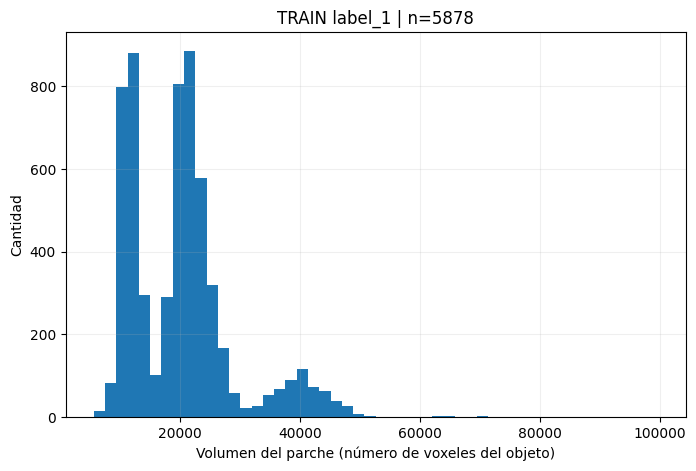

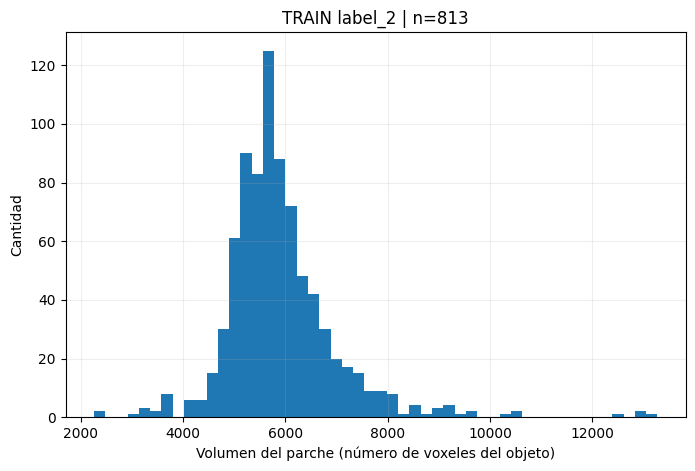

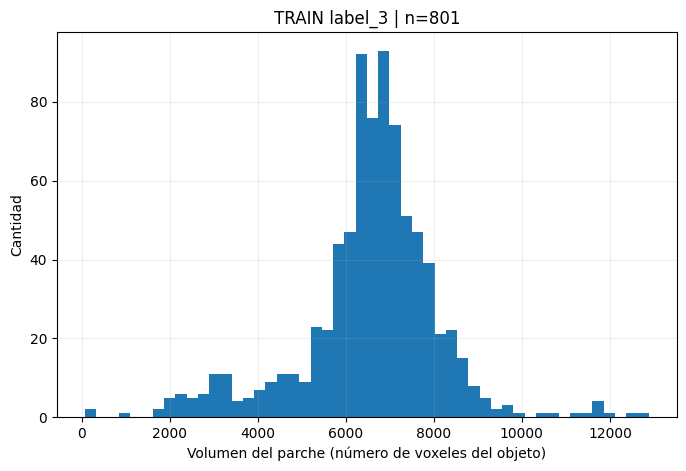

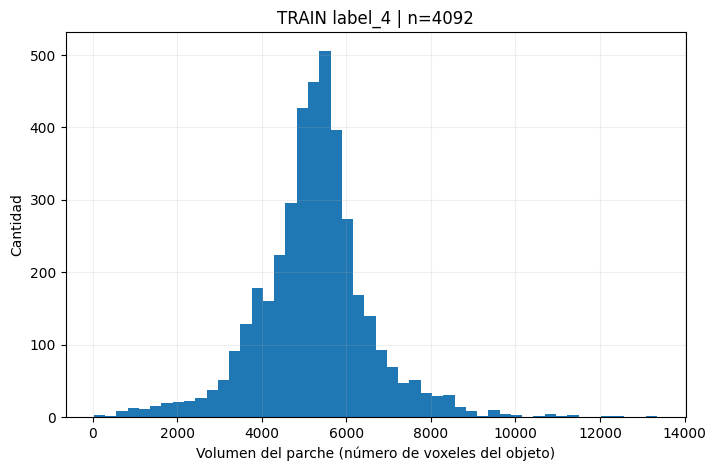

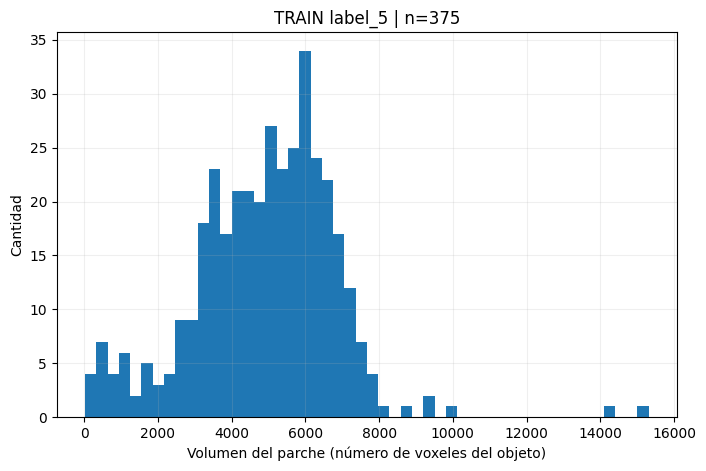

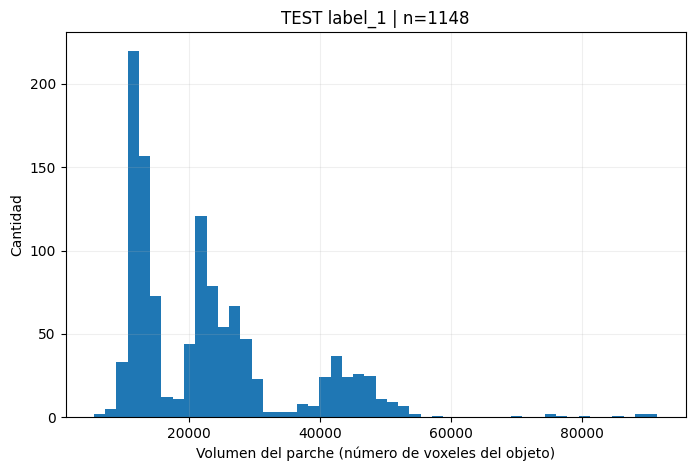

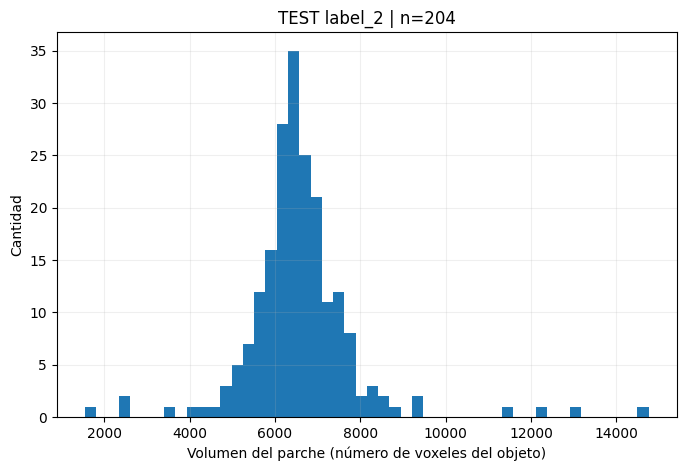

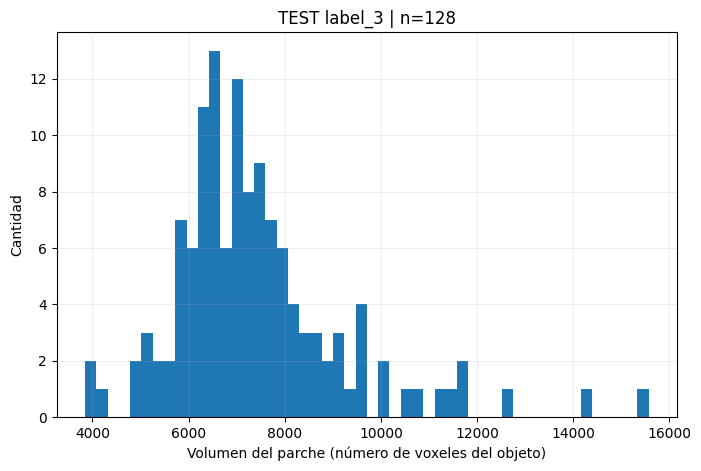

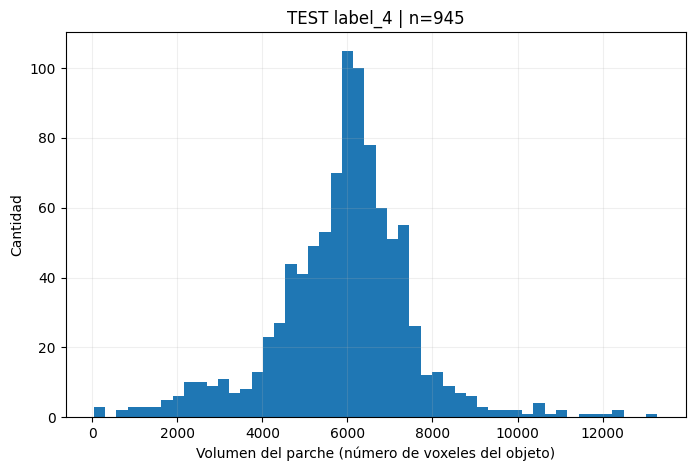

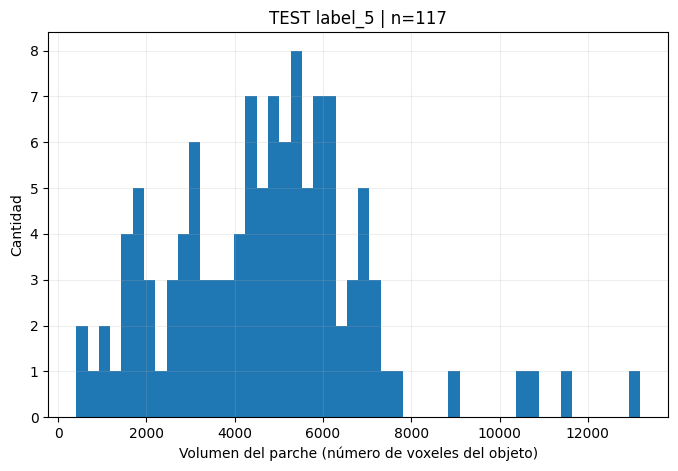

In [ ]:
# Grafica histogramas del volumen (número de voxeles > threshold) por clase
def plot_histograms(vol_dict, title_prefix="", bins=50, log_y=False):
    for lab, vols in vol_dict.items():
        vols = [v for v in vols if v > 0]
        if len(vols) == 0:
            print(f"{lab} sin datos >0")
            continue

# Crea figura por clase
        plt.figure(figsize=(8,5))
        plt.hist(vols, bins=bins)
        plt.title(f"{title_prefix} {lab} | n={len(vols)}")
        plt.xlabel("Volumen del parche (número de voxeles del objeto)")
        plt.ylabel("Cantidad")
        if log_y:
            plt.yscale("log")
        plt.grid(True, alpha=0.2)
        plt.show()

# Histogramas para TRAIN
plot_histograms(train_vols, title_prefix="TRAIN", bins=50, log_y=False)
# Histogramas para TEST
plot_histograms(test_vols, title_prefix="TEST", bins=50, log_y=False)


/tmp/ipython-input-2473421588.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(values, labels=labels, showfliers=True)


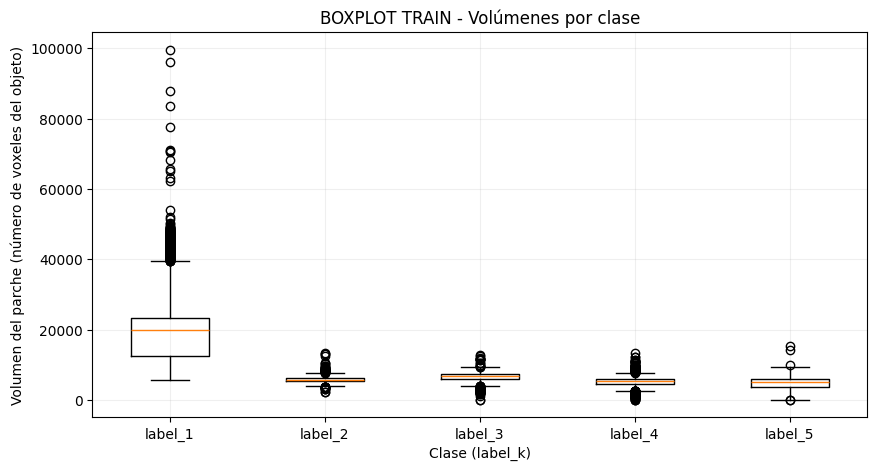

/tmp/ipython-input-2473421588.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(values, labels=labels, showfliers=True)


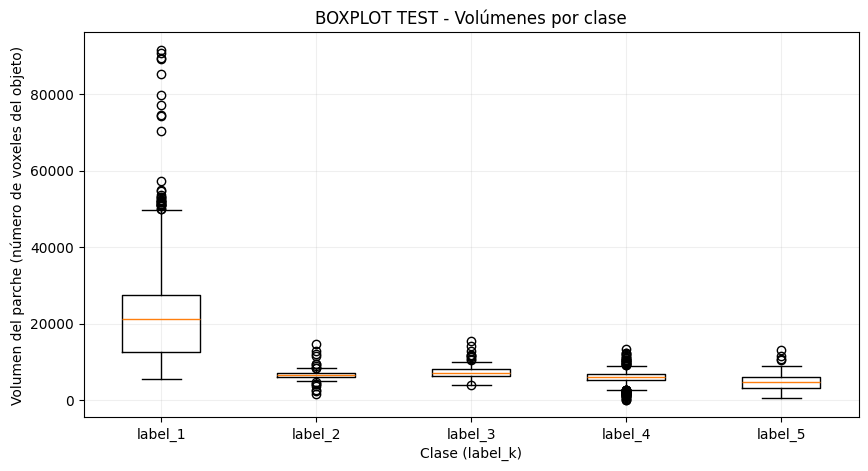

In [ ]:
# Grafica boxplots del volumen del parche por clase para comparar distribución y outliers
def plot_boxplot(vol_dict, title=""):
    labels = []
    values = []
    for lab, vols in vol_dict.items():
        vols = [v for v in vols if v > 0]
        if len(vols) == 0:
            continue
        labels.append(lab)
        values.append(vols)
 # Dibuja el boxplot comparativo entre clases
    plt.figure(figsize=(10,5))
    plt.boxplot(values, labels=labels, showfliers=True)
    plt.title(title)
    plt.xlabel("Clase (label_k)")
    plt.ylabel("Volumen del parche (número de voxeles del objeto)")
    plt.grid(True, alpha=0.2)
    plt.show()

plot_boxplot(train_vols, title="BOXPLOT TRAIN - Volúmenes por clase")
plot_boxplot(test_vols,  title="BOXPLOT TEST - Volúmenes por clase")


In [ ]:
# Calcula y muestra un resumen estadístico por clase para los volúmenes de parches
def stats_summary(vol_dict, name=""):
    print(f"\n=== RESUMEN {name} ===")
    for lab, vols in vol_dict.items():
        vols = np.array([v for v in vols if v > 0], dtype=np.int64)
        if vols.size == 0:
            print(lab, "sin datos")
            continue
        # Imprime estadísticas descriptivas para comparar distribuciones entre clases
        print(
            f"{lab}: n={vols.size} | "
            f"min={vols.min()} | p25={np.percentile(vols,25)} | "
            f"median={np.median(vols)} | p75={np.percentile(vols,75)} | "
            f"max={vols.max()}"
        )

stats_summary(train_vols, "TRAIN")
stats_summary(test_vols, "TEST")



=== RESUMEN TRAIN ===
label_1: n=5878 | min=5663 | p25=12380.25 | median=19974.5 | p75=23255.75 | max=99570
label_2: n=813 | min=2257 | p25=5302.0 | median=5747.0 | p75=6293.0 | max=13272
label_3: n=801 | min=81 | p25=6037.0 | median=6710.0 | p75=7355.0 | max=12882
label_4: n=4092 | min=28 | p25=4564.75 | median=5287.0 | p75=5865.0 | max=13360
label_5: n=375 | min=24 | p25=3688.0 | median=5091.0 | p75=6117.5 | max=15314

=== RESUMEN TEST ===
label_1: n=1148 | min=5507 | p25=12632.25 | median=21329.5 | p75=27479.0 | max=91546
label_2: n=204 | min=1548 | p25=6078.75 | median=6469.0 | p75=7013.25 | max=14763
label_3: n=128 | min=3847 | p25=6366.25 | median=7030.5 | p75=8008.0 | max=15571
label_4: n=945 | min=37 | p25=5126.0 | median=6035.0 | p75=6764.0 | max=13291
label_5: n=117 | min=414 | p25=3134.0 | median=4768.0 | p75=5983.0 | max=13181
